# Dimensionsreduktion

## Überblick

Wir betrachten Methoden, um lineare Modelle bei Regressionsproblemen zu vereinfachen
bzw. bei hochdimensionalen Datensätzen Dimensionsreduktionen durchzuführen.
Das wesentliche Werkzeug dazu ist die **Singulärwertzerlegung**

Die Singulärwertzerlegung kommt ursprünglich aus der linearen Algebra.
Dort zeigt man, dass jede Matrix $A\in\mathbb{R}^{m\times n}$ sich in
\begin{equation*} 
A = U\Sigma V^T
\end{equation*}
mit
\begin{equation*} 
\quad
U\in\mathbb{R}^{m\times m}, 
\quad
V\in\mathbb{R}^{n\times n},  
\quad
\Sigma = \text{diag}\big(\sigma_1, \ldots, \sigma_r, 0, \ldots,0 \big)\in\mathbb{R}^{m\times n}
\end{equation*}
und
$\sigma_1 \ge \ldots \ge \sigma_r > 0$,
$r \le \min(m,n)$,
zerlegen lässt, wobei $U,V$ orthonormal sind.

Geometrisch bedeutet das, dass man immer orthonormale Basen
$V$ im Urbild-Raum und $U$ im Bildraum finden kann, so dass sich die zu $A$ gehörige
lineare Abbildung bezüglich dieser
Basen als Diagonalmatrix $\Sigma$ darstellen lässt.

Die Singulärwertzerlegung stellt somit eine Verallgemeinerung der Diagonalisierbarkeit
quadratischer Matrizen (und damit der Eigenwert- und Eigenvektor-Berechnung) dar.

Andererseits kann man die Berechnung von Singulärwerten und Singulärvektoren aber auch
als restringiertes konvexes Optimierungsproblem beschreiben. Für den ersten Spaltenvektor $v_1$  von $V$ gilt
\begin{equation*} 
v_1 = \text{argmax}_{\|v\|_2^2=1}f(v) = \text{argmax}_{\|v\|_2^2 \leq 1}f(v),
\quad
f(v) = \|A v\|_2^2,
\quad
f(v_1) = \sigma_1^2.
\end{equation*}
Allgemein gilt mit $V_k = \text{span}(v_1,\ldots,v_k)$
\begin{equation*} 
v_k = \text{argmax}_{\|v\|_2^2=1, v\bot V_{k-1}}f(v) = \text{argmax}_{\|v\|_2^2\leq 1, v\bot V_{k-1}}f(v),
\quad
f(v) = \|Av\|_2^2,
\quad
f(v_k) = \sigma_{k}^2.
\end{equation*}

Für die numerische Berechnung von Singulärwerten und -vektoren haben
wir damit die Möglichkeit, Algorithmen aus beiden Bereichen anzuwenden.
Welche Verfahren dabei effizienter sind, hängt stark von der konkreten Aufgabenstellung
ab.

## Modellvereinfachung

### Regressionsproblem

Wir betrachten wieder das lineares Regressionsproblem aus dem letzten Abschnitt

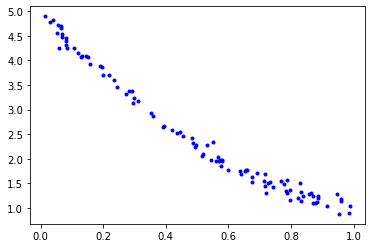

In [1]:
import autograd.numpy as np
from autograd import jacobian

import scipy as sp
import matplotlib.pyplot as plt
import sympy as sy

seed = 17

from IPython.display import Math
%precision 5
np.set_printoptions(precision=4)


m = 100

delta = 1e-1

h = lambda x : 5 - 7*x + 3 * x**2

np.random.seed(seed)
x = np.random.rand(m)
y = h(x) + delta * np.random.randn(*x.shape)

%matplotlib inline
plt.plot(x, y, 'b.');

benutzen aber als Modellfunktion
\begin{equation*} 
g(x,w) = w_1 + w_2\,(x-1) + w_3(x + 1)
\end{equation*}
bei unverändertem Loss
\begin{equation*} 
l(w) = \frac{1}{m}\sum_{i=1}^m l_i(w),
\quad
l_i(w) = \frac{1}{2} \big( g(x_i,w) - y_i \big)^2. 
\end{equation*}
Die Modellfunktion ist "überparametriert":

- mit $g$ können beliebige Geraden erzeugt werden

- dafür reichen aber bereits zwei Parameter

Mit
\begin{equation*} 
X = 
\begin{pmatrix}
1 & x_1 - 1 & x_1 + 1\\
\vdots & \vdots & \vdots\\
1 & x_m - 1 & x_m + 1
\end{pmatrix}
\in \mathbb{R}^{m\times 3},
\quad
\end{equation*}
und
\begin{equation*} 
w = 
\begin{pmatrix}
w_1 \\ w_2 \\w_3
\end{pmatrix},
\quad
y = 
\begin{pmatrix}
y_1\\
\vdots\\
y_m
\end{pmatrix}
\in \mathbb{R}^m
\end{equation*}
können wir $l$ umschreiben zu
\begin{equation*} 
l(x)=\frac{1}{2m} \|Xw - y\|_2^2 = \frac{1}{2m}(Xw - y)^T (Xw - y)
\end{equation*}
und erhalten
\begin{equation*} 
l'(w) = \frac{1}{m}X^T(Xw - y),
\quad
l''(w) = \frac{1}{m}X^T X.
\end{equation*}
Unsere Zielfunktion ist also nach wie vor quadratisch und konvex.

Wir wenden jetzt nacheinander die Algorithmen aus dem letzten Abschnitt an.

### GD

Direkte Anwendung von GD liefert folgende Ergebnisse.

w = [-0.9954 -2.5079 -1.5126], l(w) = 0.055993


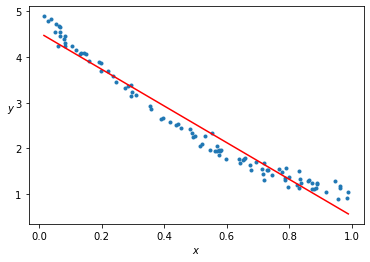

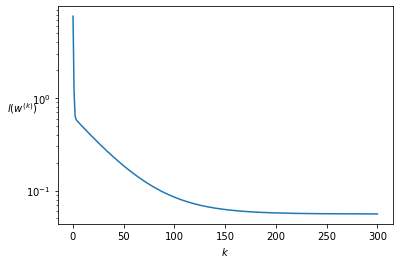

In [2]:
npar = 3

def g(x, w):
    return w[0] + w[1] * (x - 1) + w[2] * (x - 2) 
    #return w[0] + w[1] * x + w[2] * x**2 + w[3] * x**3

def l(w):
    return ((g(x, w) - y)**2).mean()

l1 = jacobian(l)

def GD(w0, l1, gamma = 1.0, nit = 20):
    ww = [w0]
    w  = w0.copy()
    
    for k in range(nit):
        w = w - gamma * l1(w)
        ww.append(w)
    
    return ww


def evalw(w, x, y):
    # Fit
    plt.figure(1)
    plt.plot(x, y, '.');
    xp = np.linspace(x.min(), x.max())
    plt.plot(xp, g(xp, w), 'r');
    plt.xlabel('$x$')
    plt.ylabel('$y$', rotation=0)

def evalwl(w, l, x, y):
    # Konvergenzgeschwindigkeit
    plt.figure(2)
    plt.semilogy(list(map(l, w)))
    plt.xlabel('$k$')
    plt.ylabel('$l(w^{(k)})$', rotation=0)
    

w0 = np.zeros(npar)
w = GD(w0, l1, gamma = 0.1, nit = 300)
evalw(w[-1], x, y)
evalwl(w, l, x, y)
print("w = {}, l(w) = {:f}".format(w[-1], l(w[-1])))

Ändern wir den Startwert so erhalten wir zwar einen ähnlichen Wert für $l$, aber
einen anderen Parametersatz $w$.

w = [-0.6512 -2.828  -1.1768], l(w) = 0.056096


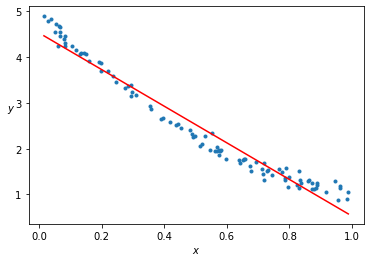

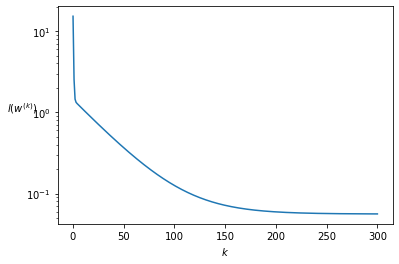

In [3]:
w0 = np.ones(npar)
w = GD(w0, l1, gamma = 0.1, nit = 300)
evalw(w[-1], x, y)
evalwl(w, l, x, y)
print("w = {}, l(w) = {:f}".format(w[-1], l(w[-1])))

GD zeigt dabei unverändertes Konvergenzverhalten.

### Newton

Die Iterationsvorschrift für das einfache Newton-Verfahren lautet
\begin{equation*} 
w^{(k+1)} = w^{(k)} -  l''\big( w^{(k)} \big)^{-1} l'\big( w^{(k)} \big).
\end{equation*}
In unserem Beispiel ist 
\begin{equation*} 
l''(w) = \frac{1}{m}X^T X, 
\quad
X = 
\begin{pmatrix}
1 & x_1 - 1 & x_1 + 1\\
\vdots & \vdots & \vdots\\
1 & x_m - 1 & x_m + 1
\end{pmatrix}.
\end{equation*}
Da die Spalten von $X$ linear abhängig sind, hat $X$ keinen vollen Rang so dass die Hessematrix $l''$ singulär (nur positiv semidefinit)
ist. Somit ist das einfache Newton-Verfahren nicht anwendbar.

Singuläre Hesse-Matrizen treten bei Optimierungsproblemen häufig auf, weshalb es eine ganze Reihe von modifizierten Newton-Varianten gibt (gedämpfte Newton-Verfahren, Quasi-Newton, Gauß-Newton, Trust-Region, siehe auch [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)), die 
dieses Problem auf unterschiedliche Art und Weise umschiffen.

Wir wenden BFGS an, ein Quasi-Newton-Verfahren dass adaptiv
spd-Näherungen $B^{(k)}$ der Hesse-Matrix benutzt. Für
$w^{(0)}, B^{(0)}$ gegeben berechnet man
\begin{align*}
B^{(k)} p^{(k)} 
&= -l'(w^{(k)}) \\
w^{(k+1)} 
&= w^{(k)} + \gamma^{(k)} p^{(k)} \\
B^{(k+1)} 
&= B^{(k)} + \frac{ y^{(k)} {y^{(k)}}^T }{ {h^{(k)}}^T y^{(k)} } 
- \frac{ u^{(k)}{u^{(k)}}^T }{ {h^{(k)}}^T u^{(k)} }
\end{align*}
mit
\begin{equation*} 
h^{(k)} = w^{(k+1)} - w^{(k)},
\quad
y^{(k)}= l'(w^{(k+1)}) - l'(w^{(k)}),
\quad
u^{(k)} = B^{(k)} h^{(k)}.
\end{equation*}
$\gamma^{(k)}$ wird dabei durch Liniensuche bestimmt.

Wir benutzen die BFGS Implementierung von [SciPy](https://www.scipy.org/) und erhalten für zwei unterschiedliche Startwerte folgende Ergebnisse.

Optimization terminated successfully.
         Current function value: 0.055920
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
w = [-1.0151 -2.532  -1.5169], l(w) = 0.055920


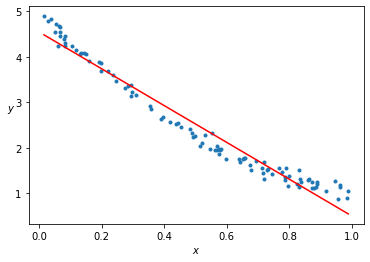

In [4]:
from scipy.optimize import minimize

w0 = np.zeros(npar)
w = minimize(l, w0, method = 'BFGS', jac = l1, options={'disp': True} ).x
evalw(w, x, y)
print("w = {}, l(w) = {:f}".format(w, l(w)))

Optimization terminated successfully.
         Current function value: 0.055920
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
w = [-0.6817 -2.8653 -1.1836], l(w) = 0.055920


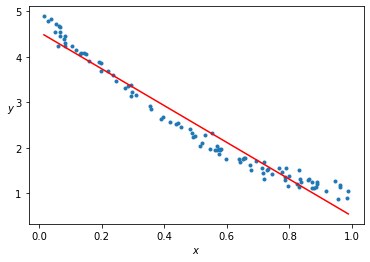

In [5]:
w0 = np.ones(npar)
w = minimize(l, w0, method = 'BFGS', jac = l1, options={'disp': True} ).x
evalw(w, x, y)
print("w = {}, l(w) = {:f}".format(w, l(w)))

Die Ergebnisse sind vergleichbar mit denen von GD, allerdings ist
die Anzahl der Iterationen (und damit der Aufwand) deutlich geringer.

### Normalgleichungen

Wir betrachten jetzt das Normalgleichungssystem
\begin{equation*} 
X^TXw = X^Ty.
\end{equation*}
Da $X$ linear abhängige Spalten hat, ist $X^TX$
positiv semidefinit, also nicht regulär. 
Wie wir oben gesehen haben, existieren aber immer Lösungen dieses
Systems.

Wie lösen wir jetzt numerisch dieses singuläre Gleichungssystem?

Direkte Verfahren (LU, Cholesky, QR) sind prinzipiell anwendbar, leiden aber oft an Stabilitätsproblemen.

Bei den iterativen Verfahren betrachten wir wieder CGLS, wenden es auf unser Beispielproblem an
und erhalten für zwei unterschiedliche Startwerte die folgenden Ergebnisse.

w = [-1.0151 -2.532  -1.5169], l(w) = 0.055920


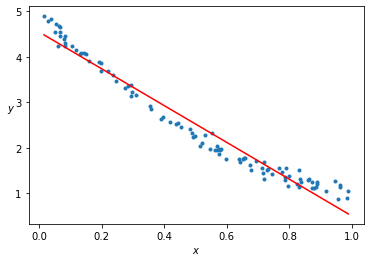

In [6]:
def CGLS(w0, X, y, nit = 20):
    ww = [w0]
    w = w0.copy()
    s = y - X.dot(w)
    r = X.T.dot(s)
    p = r.copy()
    
    rr = r.dot(r)
    
    for k in range(nit):
        Xp  = X.dot(p)
        al  = rr / Xp.dot(Xp)
        w   = w + al * p
        s   = s - al * Xp
        r   = X.T.dot(s)
        rrn = r.dot(r)
        be  = rrn / rr
        p   = r + be * p
        
        rr = rrn
        ww.append(w)
        
    return(ww)


wX = np.eye(npar)
X = np.array([g(x, wX[k]) for k in range(npar)]).T

w0 = np.zeros(npar)
w = CGLS(w0, X, y)
evalw(w[-1], x, y)
print("w = {}, l(w) = {:f}".format(w[-1], l(w[-1])))

w = [-0.6817 -2.8653 -1.1836], l(w) = 0.055920


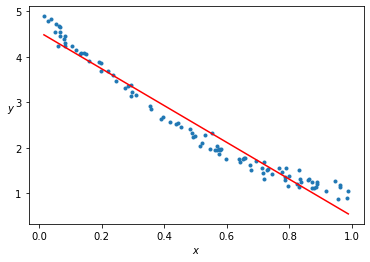

In [7]:
w0 = np.ones(npar)
w = CGLS(w0, X, y)
evalw(w[-1], x, y)
print("w = {}, l(w) = {:f}".format(w[-1], l(w[-1])))

CGLS erreicht bereits im zweiten Schritt wieder (eine) exakte Lösung der Normalgleichungen. Je nach Startwert erhält man unterschiedliche Parameter $w$, die aber die selbe Modellfunktion parametrieren.

### Pseudoinverse und Singulärwertzerlegung (SVD)

Um diese Mehrdeutigkeiten zu beseitigen suchen wir jetzt eine Lösung $w^+$ der Normalgleichungen, die selbst möglichst kleine Norm $\|w\|_2$ hat, also
\begin{equation*} 
\|X w -y \|_2^2 \to \min
\quad\text{und}\quad
\|w \|_2^2 \to \min.
\end{equation*}
Dieses Problem hat immer eine eindeutige Lösung $w^+$. Sie hängt linear von $y$ ab,
d.h. zu $X\in\mathbb{R}^{m\times n}$ gibt es eine eindeutige Matrix $X^+\in\mathbb{R}^{n\times m}$,
die **Pseudoinverse**, mit
\begin{equation*} 
w^+ = X^+ y.
\end{equation*}
Es gibt direkte Verfahren (über QR-Zerlegungen) um $X^+$ zu berechnen, in der Praxis
wird $X^+$ in der Regel über die **Singulärwertzerlegung** bestimmt.

Jede Matrix $X\in\mathbb{R}^{m\times n}$ lässt sich zerlegen
in
\begin{equation*} 
X = U\Sigma V^T, 
\end{equation*}
wobei
$U\in\mathbb{R}^{m\times m}$, 
$V\in\mathbb{R}^{n\times n}$ orthonormal sind und
\begin{equation*} 
\Sigma = \text{diag}\big(\sigma_1, \ldots, \sigma_r, 0, \ldots,0 \big)\in\mathbb{R}^{m\times n},
\quad r \le \min(m,n).
\end{equation*}
Dabei sind
\begin{equation*} 
\sigma_1 \ge \ldots \ge \sigma_r > 0
\end{equation*}
die **Singulärwerte** und $r$ der Rang von $X$.

Damit können wir jetzt das Normalgleichungssystem mit Zusatzbedingung (also $w^+ = X^+ y$) 
über das dazu äquivalente Optimierungsproblem 
\begin{equation*} 
\|X w -y \|_2^2 \to \min
\quad\text{und}\quad
\|w \|_2^2 \to \min
\end{equation*}
ganz einfach lösen. 
Für orthonormale Matrizen $Q$ gilt $\|Qw \|_2 = \|w \|_2$, $Q^{-1}=Q^T$, und somit
\begin{align*} 
\|X w -y \|_2^2 
&= \|U\Sigma V^T w -y \|_2^2\\
&= \|\Sigma V^T w - U^Ty \|_2^2\\
&= \|\Sigma \tilde{w} - \tilde{y} \|_2^2
\end{align*}
mit
\begin{equation*} 
\tilde{w} = V^T w, \quad \|\tilde{w}\|_2^2 = \|w\|_2^2
\end{equation*}
und $\tilde{y} = U^Ty$. Wir müssen jetzt also die Lösung $\tilde{w}^+$ von
\begin{equation*} 
\|\Sigma \tilde{w} - \tilde{y} \|_2^2 \to \min
\quad\text{und}\quad
\|\tilde{w} \|_2^2 \to \min
\end{equation*}
bestimmen und erhalten $w^+ =V\tilde{w}^+$.

Nun ist aber
\begin{equation*} 
\|\Sigma \tilde{w} - \tilde{y} \|_2^2 = \sum_{i=1}^r (\sigma_i \tilde{w}_i - \tilde{y}_i\big)^2 + \sum_{i=r+1}^m\tilde{y}_i^2,
\end{equation*}
so dass $\|\Sigma \tilde{w} - \tilde{y} \|_2^2$ minimal wird für
\begin{equation*} 
\tilde{w}^+_i = \frac{\tilde{y}_i}{\sigma_i}, \quad i=1,\ldots,r.
\end{equation*}
Damit sind die ersten $r$ Komponenten von $\tilde{w}^+$ bestimmt.
Wegen
\begin{equation*} 
\|\tilde{w}\|_2^2 = \sum_{i=1}^n \tilde{w}_i^2,
\end{equation*}
wird $\|\tilde{w}\|_2^2$ minimal für
\begin{equation*} 
\tilde{w}^+_i = 0, \quad i=r+1,\ldots,n.
\end{equation*}
Somit ist
\begin{equation*} 
\tilde{w}^+ = \Big(\frac{\tilde{y}_1}{\sigma_1}, \ldots, \frac{\tilde{y}_r}{\sigma_r}, 0, \ldots, 0 \Big)^T
\end{equation*}
und $w^+ =V\tilde{w}^+$. Wegen $\tilde{y} = U^Ty$ kann man $w^+$ jetzt schreiben als
\begin{equation*} 
w^+ = V\Sigma^+ U^T y, 
\quad
\Sigma^+ = \text{diag}\Big(\frac{1}{\sigma_1}, \ldots, \frac{1}{\sigma_r}, 0, \ldots, 0 \Big)\in\mathbb{R}^{n\times m}.
\end{equation*}
Ist also 
\begin{equation*} 
X = U\Sigma V^T
\end{equation*}
eine Singulärwertzerlegung von $X$, dann ist die Pseudoinverse
\begin{equation*} 
X^+ = V\Sigma^+ U^T
\end{equation*}
und $\Sigma^+$ ist die Pseudoinverse von $\Sigma$.

Wie berechnet man nun numerisch eine Singulärwertzerlegung?
Einen ersten Hinweis bekommt man durch folgende Beziehungen
\begin{equation*} 
X = U \Sigma V^T
\quad\Rightarrow\quad
X^T X = V \Sigma^T \Sigma V^T,
\quad
X X^T = U \Sigma \Sigma^T U^T.
\end{equation*}
Da $U,V$ orthonormal und quadratisch und $\Sigma^T \Sigma$, $\Sigma \Sigma^T$  Diagonalmatrizen sind,
haben wir damit eine Eigenwert-/Eigenvektorzerlegung der beiden quadratischen
symmetrischen Matrizen $X^T X$, $X X^T$,
d.h.

- $\sigma_i^2$, $i = 1,\ldots,r$, sind die positiven Eigenwerte von $X^T X$, $X X^T$, alle weiteren Eigenwerte sind $0$

- die Spalten von $V$ sind die Eigenvektoren von $X^T X$

- die Spalten von $U$ sind die Eigenvektoren von $X X^T$

Damit könnte man numerisch wie folgt vorgehen:

- berechne (z.B. mit QR-Iteration mit Shift) alle Eigenwerte $\lambda_i$ und Eigenvektoren $v_i$ von $X^T X$,
  \begin{equation*} 
  \lambda_1 \ge \ldots \ge \lambda_r >0, 
  \quad 
  \lambda_{r+1} = \ldots = \lambda_n = 0
  \end{equation*}

- $\sigma_i = \sqrt{\lambda_i},\quad i = 1,\ldots,r$

- $V = \big(v_1,\ldots,v_n \big)$

- aus $U \Sigma = XV$ folgt für die $i$-te Spalte der Matrizen 
  \begin{equation*} 
  (U \Sigma)_i = u_i \sigma_i,
  \quad 
  (XV)_i = Xv_i
  \end{equation*}
  somit
  \begin{equation*} 
  u_i  
  = \frac{1}{\sigma_i}Xv_i,
  \quad i = 1,\ldots,r
  \end{equation*}
- ergänze $u_1,\ldots,u_r$ zu einer Orthonormalbasis $u_1,\ldots,u_m$ (z.B. mit modifiziertem Gram-Schmidt)
  und setze
  \begin{equation*} 
  U = \big(u_1,\ldots,u_m \big)
  \end{equation*}

Alternativ könnte man natürlich auch über die Eigenwerte/Eigenvektoren von $XX^T$ die SVD berechnen.
Beide Varianten sind nicht optimal (Aufwand, Kondition). 

Der heute gebräuchlichste Algorithmus vermeidet
die explizite Berechnung von $X^TX$. Er basiert zunächst auf der Beobachtung, dass die Singulärwerte
von $X$ identisch sind mit den Singulärwerten von
\begin{equation*} 
TXS, \quad T,S \text{ orthonormal.}
\end{equation*}

Im ersten Schritt wird mit einer Folge von Householder-Transformationen von links und rechts $T,S$ so bestimmt, dass
\begin{equation*} 
TXS = R, \quad R \text{ bidiagonal,}
\end{equation*}
was das Analogon zur Hessenbergtransformation bei der Eigenwertberechnung ist.

Der zweite Schritt beruht auf einer angepassten QR-Iteration zur Berechnung der
Singulärwerte (Wurzel der Eigenwerte von $R^TR$), ohne $R^TR$ explizit zu berechnen.

Wir wenden nun die Pseudoinverse an, um unser unterbestimmtes Regressionsproblem zu lösen.

w = [-1.0151 -2.532  -1.5169], l(w) = 0.055920


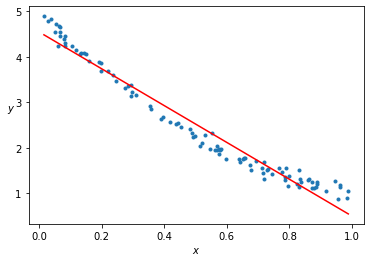

In [8]:
w = np.linalg.pinv(X).dot(y)
evalw(w, x, y)
print("w = {}, l(w) = {:f}".format(w, l(w)))

### Abgeschnittene Singulärwertzerlegung (TSVD)

Jede Matrix $X\in\mathbb{R}^{m\times n}$ kann
in
\begin{equation*} 
X = U\Sigma V^T, 
\end{equation*}
$U\in\mathbb{R}^{m\times m}$, 
$V\in\mathbb{R}^{n\times n}$, 
\begin{equation*} 
\Sigma = \text{diag}\big(\sigma_1, \ldots, \sigma_r, 0, \ldots,0 \big)\in\mathbb{R}^{m\times n},
\quad
r \le \min(m,n)
\end{equation*}
zerlegt werden.

Da in $\Sigma$ nur die ersten $r$ Diagonalelemente ungleich $0$ sind
folgt
\begin{equation*} 
X 
= U\Sigma V^T
= \sum_{i=1}^r u_i \sigma_i v_i^T
= U_r\Sigma_r V_r^T
\end{equation*}
mit
\begin{align*} 
U_r 
&= \big(u_1,\ldots,u_r \big) \in \mathbb{R}^{m\times r}, \\
\Sigma_r 
&= \text{diag}\big(\sigma_1,\ldots,\sigma_r \big) \in \mathbb{R}^{r\times r}, \\
V_r 
&= \big(v_1,\ldots,v_r \big) \in \mathbb{R}^{n\times r}
\end{align*}
sowie
\begin{equation*} 
X^+ = V_r \Sigma_r^{-1} U_r^T.
\end{equation*}

Ist $r \ll \min(m,n)$, so sind Matrixprodukte über $U_r\Sigma_r V_r^T$,
$V_r \Sigma_r^{-1} U_r^T$ deutlich günstiger zu Berechnen als Produkte die direkt $X$, $X^+$ benutzen.

Nehmen wir nun an, dass $X\in\mathbb{R}^{m\times n}$ Singulärwerte 
$\sigma_1 \ge \ldots \ge \sigma_k \ge \sigma_{k+1} \ge \ldots \ge \sigma_r > 0$ mit
\begin{equation*} 
\sigma_1  \gg \sigma_{k+1}
\end{equation*}
hat. Damit erhalten wir
\begin{equation*} 
X 
= U\Sigma V^T
= \sum_{i=1}^r u_i \sigma_i v_i^T
\approx \sum_{i=1}^k u_i \sigma_i v_i^T
= U_k\Sigma_k V_k^T
= X_k
\end{equation*}
$X_k$ ist eine Rang-$k$-Approximation der Rang-$r$-Matrix $X$ (abgeschnittene Singulärwertzerlegung, TSVD), also
eine vereinfachte Version unseres ursprünglichen linearen
Modells, das durch $X$ repräsentiert wird.
Wegen
\begin{equation*} 
X_k = U_k\Sigma_k V_k^T
\end{equation*}
ist $X_k$ für $k\ll r$ numerisch viel effizienter zu bearbeiten als $X$.

Wir wenden nun die SVD auf unser Regressionsproblem von oben an und erhalten Singulärwerte

In [9]:
U,s,VT = np.linalg.svd(X)
V = VT.T

s

array([1.8869e+01, 2.7241e+00, 9.2795e-16])

Offensichtlich können wir hier $k = 2$, wählen d.h.  zwei Parameter reichen aus.
Betrachten wir die zugehörigen Singulärbasen $V$

In [10]:
V

array([[-0.5222,  0.6277, -0.5774],
       [ 0.2825,  0.7661,  0.5774],
       [ 0.8047,  0.1383, -0.5774]])

dann sehen wir, dass Parameterkombinationen $w = s(-1,1,-1)^T$, $s\in\mathbb{R}$, vernachlässigbar sind.
Durch Einschränkung auf die ersten beiden Singulärbasen kann man das Modell dann vereinfachen und wir erhalten

w = [-1.0151 -2.532  -1.5169], l(w) = 0.055920


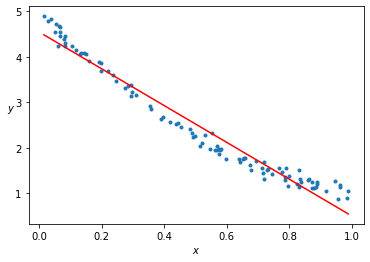

In [11]:
k = 2
Xk = X.dot(V[:,:k])

wk = np.linalg.pinv(Xk).dot(y)

w = V[:,:k].dot(wk)

evalw(w, x, y)
print("w = {}, l(w) = {:f}".format(w, l(w)))

Jetzt betrachten wir zu den selben Daten $x_i,y_i$ das Regressionsproblem mit Modellfunktion
\begin{equation*} 
g(x,w) = w_1 + w_2 \, x + w_3 \, x^2 + w_4 \, x^3
\end{equation*}

Einfache Regression liefert das folgende Ergebnis

w = [ 4.9521 -6.5425  2.0585  0.5842], l(w) = 0.010212


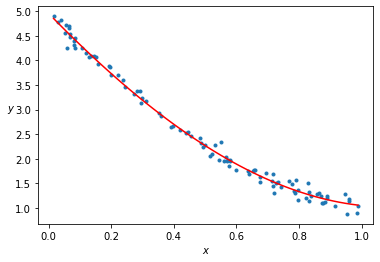

In [12]:
npar = 4

def g(x, w):
    return w[0] + w[1] * x + w[2] * x**2 + w[3] * x**3


wX = np.eye(npar)
X = np.array([g(x, wX[k]) for k in range(npar)]).T

w = np.linalg.pinv(X).dot(y)

evalw(w, x, y)
print("w = {}, l(w) = {:f}".format(w, l(w)))

Als Singulärwerte von $X$ erhalten wir

In [13]:
wX = np.eye(npar)
X = np.array([g(x, wX[k]) for k in range(npar)]).T

U,s,VT = np.linalg.svd(X)
V = VT.T

s

array([12.3789,  4.0561,  0.8277,  0.0902])

Hier würden wir bei $k=3$ abschneiden. Die Regression auf den reduzierten Daten liefert dann

w = [ 4.853  -5.3505 -0.8073  2.4439], l(w) = 0.011277


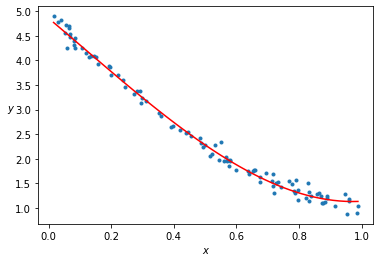

In [14]:
k = 3
Xk = X.dot(V[:,:k])

wk = np.linalg.pinv(Xk).dot(y)

w = V[:,:k].dot(wk)

evalw(w, x, y)
print("w = {}, l(w) = {:f}".format(w, l(w)))

## Dimensionsreduktion über Principle Component Analysis (PCA)

### Motivation

Oft sind die Daten in Form hochdimensionaler Vektoren
$x_j\in \mathbb{R}^m$, $j=1,\ldots,n$, also
\begin{equation*} 
X = (x_1,\ldots,x_n) \in \mathbb{R}^{m \times n}
\end{equation*}
mit $m$ groß gegeben. Ein typische Beispiel ist die Verarbeitung
von Bildern ($m$ ist die Anzahl der Pixel multipliziert mit der Anzahl der Farbkanäle).

Die direkte Anwendung von numerischen Algorithmen ist dann meistens mit großem Rechenaufwand verbunden.
Deshalb versucht man, die Dimension der Daten zunächst zu reduzieren
und zwar so, dass der dadurch entstehende Informationsverlust möglichst gering ist.

Wir betrachten den folgenden zweidimensionalen Beispieldatensatz

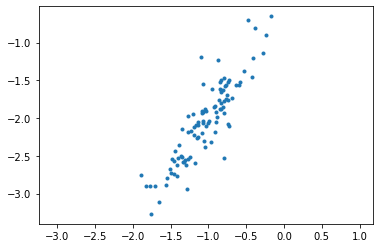

In [15]:
from sklearn.datasets import make_blobs

X,y = make_blobs(n_features = 2, centers = 1, random_state = seed)

np.random.seed(seed)
T = np.random.rand(2,2)

X = X.dot(T).T

plt.scatter(*X, marker = '.')
plt.axis('equal');

Offensichtlich gibt es eine Richtung, in der die Daten
stark variieren. Senkrecht dazu ist die Variation eher gering.

Zur Datenreduktion könnte man nun eine Gerade in die Richtung
der starken Variationen legen und die Projektionen der Daten
auf diese Gerade betrachten.

Die Projektion für einen Datenpunkt $x_i$ ist ein Skalar, also eine
eindimensionale Größe ("Koordinate entlang der Geraden")

Wenn diese Projektionen für die einzelnen Datenpunkte
sich hinreichend stark unterscheiden, dann kann man z.B. ein
Klassifikationsverfahren statt auf den zweidimensionalen
Originaldaten ohne große Verluste auch auf den eindimensionlen
Projektionen der Daten durchführen.

Um die weiteren Betrachtungen zu vereinfachen, zentrieren
wir den Datensatz. Den allgemeinen Fall behandeln wir im Anschluss.

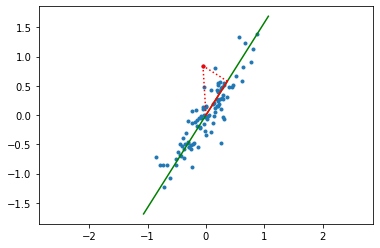

In [16]:
X = X - X.mean(axis=1).reshape(-1,1)

U, s, VT = np.linalg.svd(X)
v = U[: ,0]

plt.scatter(*X, marker = '.')
plt.axis('equal');

plt.plot(*(np.c_[-v, v] * 2), 'g')

Xi = X[:,45]
plt.plot(*Xi, 'r.')

pXi = Xi.dot(v) * v
eXi = Xi - pXi

plt.plot(*np.c_[0*pXi, pXi], 'r');
plt.plot(*np.c_[pXi, Xi], 'r:');
plt.plot(*np.c_[0*pXi, Xi], 'r:');

### Mathematische Formulierung

Gegeben ist also ein zentrierter Datensatz
\begin{equation*} 
x_j \in \mathbb{R}^m, \quad j = 1,\ldots,n,
\quad
\bar{X} = \frac{1}{n} \sum_{j=1}^n x_j = 0.
\end{equation*}
Wir suchen eine Gerade
\begin{equation*} 
g(s) = s \, u, 
\quad s\in \mathbb{R}, \quad u \in \mathbb{R}^m \quad\text{mit}\quad \|u\|_2 = 1,
\end{equation*}
so dass die Varianz 
\begin{align*} 
V_1(u) 
&= \frac{1}{n-1}\sum_{j=1}^n (x_j,u)_2^2\\
&= \frac{1}{n-1}(X^T u, X^T u)_2\\
%&= \frac{1}{n-1}u^T X X^T u\\
&= \frac{1}{n-1} \|X^T u\|_2^2
\end{align*}
der Projektionen von $x_i$ auf $u$ maximal wird.
Mit der Singulärwertzerlegung $X = U\Sigma V^T$ erhalten wir
\begin{align*} 
V_1(u) 
&= \frac{1}{n-1} \|V\Sigma^T U^T u\|_2^2\\
&= \frac{1}{n-1} \|\Sigma^T z\|_2^2\\
&= \frac{1}{n-1} \sum_{i=1}^r (\sigma_i z)^2\\
\end{align*}
mit
\begin{equation*} 
\quad z =  U^T u,
\quad \|z\|_2 =  \|u\|_2.
\end{equation*}

Wir müssen also das Problem
\begin{equation*} 
\max_{z} f(z), \quad g(z)= 0
\end{equation*}
für
\begin{align*} 
f(z) 
&= \sum_{i=1}^r (\sigma_i z_i)^2 = \|\Sigma^T z\|_2^2 = (\Sigma^T z, \Sigma^T z)_2,
\\
g(z) 
&= \| z\|_2^2 - 1 = (z, z)_2 - 1
\end{align*}
lösen. 
Damit neben der Zielfunktion $f$ auch die Nebenbedingung $g$ differenzierbar ist benutzen wir
nicht $\|z\|_2 = 1$ sondern äquivalent $\|z\|^2_2 = 1$.
Beide Funktionen $f$ und $g$ sind auch konvex.

Wir stellen nun die Lagrangefunktion 
\begin{equation*} 
L(z,\lambda) = f(z) - \lambda g(z)
\end{equation*} 
auf und betrachten deren stationäre Punkte.
Für die Ableitungen folgt nach der Produktregel
\begin{align*} 
\partial_z L(z, \lambda)(w)
& = (\Sigma^T w, \Sigma^T z)_2 + (\Sigma^T z, \Sigma^T w)_2- \lambda \big((w, z)_2 + (z, w)_2\big)\\
& = 2 \big((\Sigma^T w, \Sigma^T z)_2 - \lambda (w, z)_2 \big)\\
& = 2 \big(w^T\Sigma \Sigma^T z - \lambda w^T z \big)
\end{align*}
also
\begin{equation*} 
\partial_z L(z, \lambda)
= 2 \big(\Sigma \Sigma^T z - \lambda z \big)
\end{equation*}
bzw.
\begin{equation*} 
\partial_\lambda L(z, \lambda)  = \|z\|_2^2 - 1
\end{equation*}

Als notwendige Bedingung für eine Maximalstelle
$\hat{z}$ muss es ein $\hat{\lambda}\in\mathbb{R}$ geben mit
\begin{equation*} 
\partial_z L(\hat{z}, \hat{\lambda}) = 0,
\quad
\partial_\lambda L(\hat{z}, \hat{\lambda}) = 0.
\end{equation*}
Für die Maximalstelle $\hat{z}\in\mathbb{R}^m$ muss also
\begin{equation*} 
\|\hat{z}\|_2 = 1,
\quad
\Sigma \Sigma^T \hat{z} = \hat{\lambda} \hat{z}
\end{equation*}
gelten, d.h. $\hat{\lambda}$, $\hat{z}$ sind Eigenwert und Eigenvektor
der Diagonalmatrix
\begin{equation*} 
\Sigma \Sigma^T = 
\begin{pmatrix}
\sigma_1^2 \\
& \ddots\\
&& \sigma_r^2\\
&&& 0\\
&&&& \ddots
\end{pmatrix},
\end{equation*}
also
\begin{equation*} 
\hat{z} = e_i,
\quad
\hat{\lambda}_i = 
\begin{cases}
\sigma_i^2 & i = 1,\ldots,r \\
0 & i>r
\end{cases},
\end{equation*}
wobei $e_i$ der $i$-te Einheitsvektor ist.
Als Wert unserer Zielfunktion $f$ erhalten wir
\begin{equation*} 
f(\hat{z}) 
= \|\Sigma^T e_i\|_2^2
= \sigma_i^2
\end{equation*}
so dass das gesuchte Maximum für $i=1$ angenommen wird.



Für unser Ausgangsproblem erhalten wir somit
\begin{equation*} 
\hat{u} = U e_1= u_1,
\quad
V_1(\hat{u}) 
= \frac{\sigma_1^2}{n-1},
\quad
X = U\Sigma V^T,
\end{equation*}
d.h. die Gerade mit maximaler Varianz der Projektionen wird vom ersten
linken Singulärvektor $u_1$ von $X$ aufgespannt und die Varianz der Projektion
ist durch den zugehörigen Singulärwert $\sigma_i$ gegeben,
oder anders ausgedrückt, $u_1$ ist
der Eigenvektor von $C = XX^T$
zum größten Eigenwert 
$\lambda_1 = \sigma_1^2$ und
\begin{equation*} 
V_1(u_1) 
= \frac{\lambda_1}{n-1}
.
\end{equation*}

Projiziert man die Daten $X$ jetzt auf $u_1^\bot$, so reduziert sich die Dimension auf $(m-1)\times n$. Wendet man die selben Überlegungen erneut an, so erhält man 
als zweite Richtung mit der zweitgrößten Varianz
\begin{equation*} 
\hat{u} = u_2,
\quad
V_2(u_2) 
= \frac{\sigma_2^2}{n-1}.
\end{equation*}


Setzt man dies nun per Induktion weiter fort, so erhält nach $r$ Schritten 
\begin{align*} 
\mathbb{R}^{m\times n} \ni X 
&= U\Sigma V^T 
= U_r \Sigma_r V_r^T 
= U_r \tilde{X}, 
\\ 
\tilde{X} &= \Sigma_r V_r^T = U_r^T X
\in \mathbb{R}^{r\times n}
.
\end{align*}
Die $u_j$ heißen **Hauptkomponenten**
oder auch **Karhunen-Loeve-Richtungen**
zum Datensatz $X$.

Die Daten $X\in \mathbb{R}^{m\times n}$ werden in ein neues Orthonormalsystem der Dimension
$r \le m$ transformiert (Spalten von $U_r$). Die neuen Koordinaten sind die Projektionen
$\tilde{X}= U_r^T X$. Für die Varianzen der einzelnen Koordinaten gilt
\begin{equation*} 
V(\tilde{X}_{i,\cdot}) = \frac{\sigma_i^2}{n-1}, \quad i = 1,\ldots,r
\end{equation*}
also
\begin{equation*} 
V(\tilde{X}_{1,\cdot}) \ge V(\tilde{X}_{2,\cdot}) \ge \ldots \ge V(\tilde{X}_{r,\cdot}) > 0.
\end{equation*}
Außerdem gilt
\begin{equation*} 
V(X) 
= \sum_{i=1}^m V(X_{i,\cdot})
= \sum_{i=1}^r V(\tilde{X}_{i,\cdot})
= V(\tilde{X}),
\end{equation*}
d.h. in $\tilde{X}$ "stecken alle Variationen von $X$" drin, d.h. bezüglich Unterscheidungsmöglichkeiten
der Daten haben wir keine Information verloren.

Damit liegt nun folgende Vorgehensweise zur Dimensionsreduktion nahe:

- berechne $V(X)$

- bestimme zu $\varepsilon > 0$ ein
  möglichst kleines $k$ mit 
  \begin{equation*} 
  \sum_{i=1}^k V(\tilde{X}_{i,\cdot}) 
   = \frac{\sum_{i=1}^k\sigma_i^2}{n-1}
  \ge V(X) - \varepsilon
  \end{equation*}
  
- benutze statt $X\in \mathbb{R}^{m\times n}$ jetzt $\tilde{X} = U_k^TX\in \mathbb{R}^{k\times n}$

Man nimmt dabei einen (geringen) Informationsverlust ($\varepsilon > 0$) zugunsten einer
Dimensionsreduktion (oft ist $k\ll m$) in Kauf.

Bisher haben wir angenommen, dass die Daten $x_j$ zentriert sind.
Die Verallgemeinerung ist recht einfach. Sind die Daten $x_j$ beliebig, so betrachtet
man die zentrierten Größen
\begin{equation*} 
y_j = x_j - \bar{X}, \quad \bar{X} = \frac{1}{n} \sum_{j=1}^n x_j. 
\end{equation*}
Man erhält Hauptrichtungen $u_j$ und Varianzen $V(Y_{i,\cdot})$
über die Eigenvektoren und Eigenwerte von
\begin{equation*} 
C = YY^T = (X - \bar{X}) (X - \bar{X})^T,
\end{equation*}
der [Kovarianzmatrix](https://de.wikipedia.org/wiki/Kovarianzmatrix) der Originaldaten $X$.
Die neuen Koordinaten $\tilde{Y} = U_r^T(X - \bar{X})$
sind die Projektionen auf die Geraden
\begin{equation*} 
\hat{g}_j = \bar{X} + s \, u_j,
\end{equation*}
d.h. man projiziert auf affine Unterräume.

### Beispiel

Wir betrachten den folgenden Datensatz.

<IPython.core.display.Javascript object>


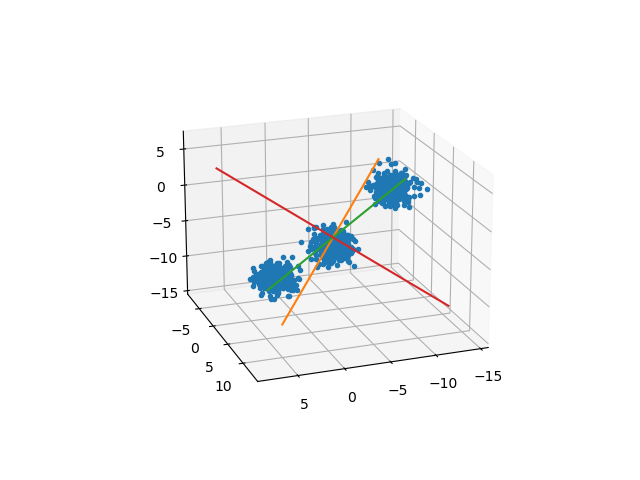

In [17]:
%matplotlib notebook

X,y = make_blobs(n_samples=1000, n_features=3, centers=3, cluster_std=1.0, random_state = seed)
X = X.T

from mpl_toolkits.mplot3d import Axes3D
plt.figure()
plt.axes(projection='3d')
plt.plot(*X, '.')
#plt.axis('equal');

m, n = X.shape

Xbar = X.mean(axis=1).reshape(-1,1)
Y = X - Xbar
U, s, VT = np.linalg.svd(Y)

for col,u in enumerate(U):
    plt.plot(*(np.c_[-u, u]*15 + Xbar));

plt.gca().view_init(20,70)

Die Hauptkomponenten sind

In [18]:
%matplotlib inline

U

array([[-0.6248, -0.6964,  0.3531],
       [ 0.2762, -0.6201, -0.7342],
       [ 0.7303, -0.3612,  0.5798]])

Für die Varianzen erhalten wir

In [19]:
vk = s**2 / (n-1)
vk

array([52.785 ,  4.4244,  1.0172])

In Scikit-Learn stehen entsprechende Methoden zur Verfügung, mit denen man diese Berechnungen sehr einfach durchführen lassen kann. Wir erhalten

<IPython.core.display.Javascript object>


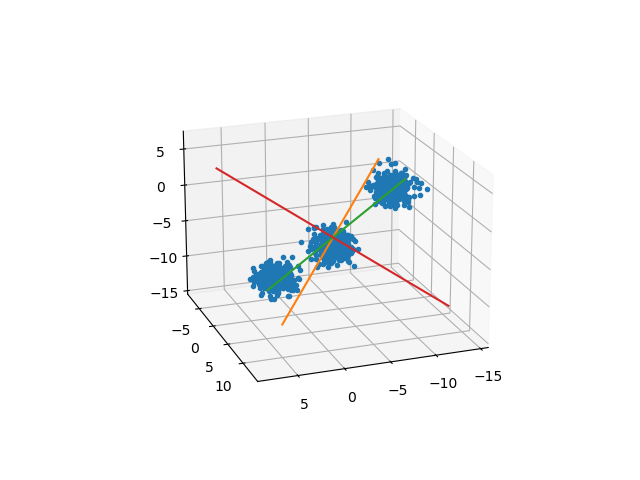

In [20]:
%matplotlib notebook

from sklearn.decomposition import PCA

plt.figure()
plt.axes(projection='3d')
plt.plot(*X, '.')
#plt.axis('equal');

pca = PCA(3)
pca.fit(X.T)

for col,u in enumerate(pca.components_.T):
    plt.plot(*(np.c_[-u, u]*15 + Xbar));

plt.gca().view_init(20,70)

mit Hauptkomponenten

In [21]:
%matplotlib inline

pca.components_.T

array([[-0.6248, -0.6964,  0.3531],
       [ 0.2762, -0.6201, -0.7342],
       [ 0.7303, -0.3612,  0.5798]])

und Varianzen

In [22]:
pca.explained_variance_

array([52.785 ,  4.4244,  1.0172])

### PCA bei Klassifikation von Ziffern

Wir wenden die oben erklärten Methoden auf die Klassifikation
von handschriftlichen Ziffern an.

In Scikit-Learn gibt es einen entsprechenden Datensatz mit
8x8-Pixel Graustufenbildern.

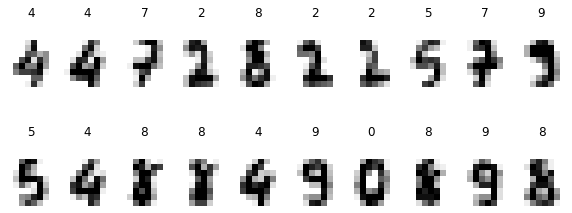

In [23]:
%matplotlib inline

from sklearn import datasets
from sklearn import svm
from sklearn import metrics

ds = datasets.load_digits()
X = ds.data
y = ds.target

def digiplot(imgs, target = [], n = 10, mi = 8, pi = 8):
    # Anzahl der Subplots
    if imgs.ndim < 2:
        images = imgs.copy()
        images.shape = np.r_[1,imgs.shape]
        ni = 1
        m = 1
        n = 1
        fig, ax = plt.subplots(m, n, figsize = [n, 2.0*m])
        ax.axis('off')
        ax = [ax]
    else:
        images = imgs
        ni = images.shape[0]
        m = (ni -1) // n + 1
        
        if m==1:
            n = ni
        
        fig, ax = plt.subplots(m, n, figsize = [n, 2.0*m])
        ax = ax.flatten()
        for axk in ax:
            axk.axis('off')        

    for k, axk in enumerate(ax[:ni]):
        axk.matshow(images[k].reshape(mi,pi), cmap = plt.cm.gray_r)
        axk.set_title(str(target[k]))

ndigi = 20
digiplot(X[-ndigi:], y[-ndigi:])

Die 1797 Bilder sind in Form einer Matrix mit Spaltenvektoren der Dimension 64 abgespeichert:

In [24]:
X.shape

(1797, 64)

### Klassifikation mit k-Means-Clustering ohne PCA

Wir lassen den Datensatz jetzt direkt mit k-Means-Clustering in 10 Klassen einteilen. Die einzelnen Daten $x_j$ haben Dimension 64. 

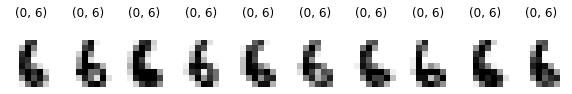

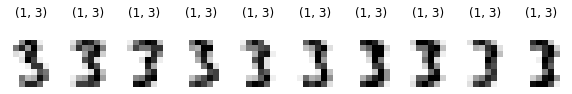

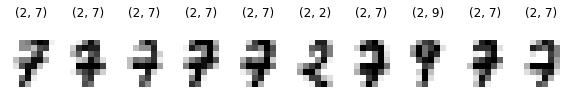

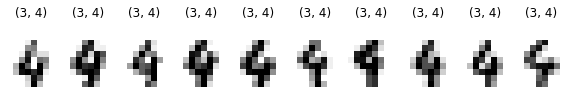

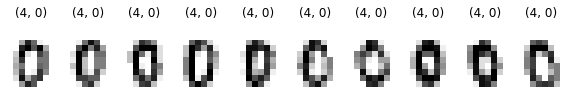

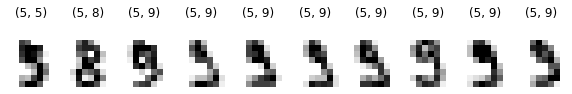

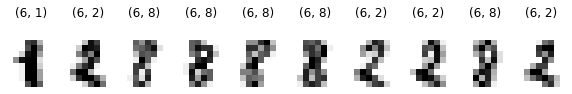

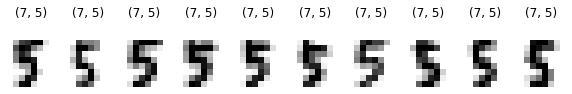

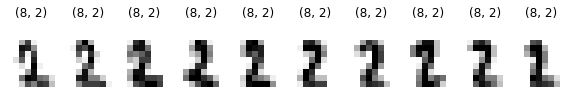

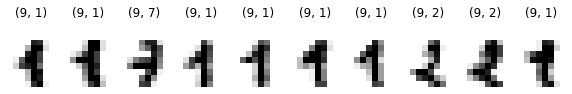

In [25]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters = 10, random_state = seed)
yd = km.fit_predict(X)

for k in range(10):
    ii = np.argwhere(yd == k).ravel()[:10]
    digiplot(X[ii], list(zip(yd[ii], y[ii])))

Zur besseren Übersicht wandeln wir die Klassennummern in die (vermeintlich) erkannten Ziffern um.

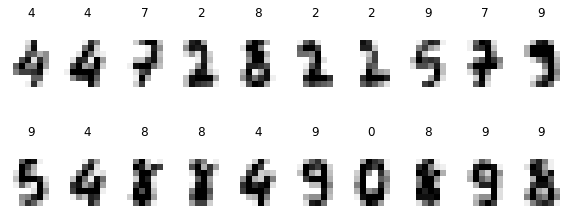

In [26]:
def ytrans(yd, y):
    ydcl = np.sort(np.unique(yd))
    
    tt = np.zeros(ydcl.shape, dtype = np.int32)
    for k,ydk in enumerate(ydcl):
        ii = np.argwhere(yd == ydk).ravel()
        u, uc = np.unique(y[ii], return_counts = True)
        tt[k] = u[uc.argmax()]
    
    ttt = np.sort(np.unique(tt))
    if ttt.shape[0] != ydcl.shape[0]:
        print("**** Fehler ****")
        tt = np.array([], dtype = np.int32)
    return(tt)

tt = ytrans(yd, y)
ydt = tt[yd]
digiplot(X[-ndigi:], ydt[-ndigi:])

Die Beurteilung des Ergebnisses erfolgt wieder mit den Standardmethoden von Scikit-Learn

In [27]:
print(metrics.classification_report(y, ydt))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       178
           1       0.60      0.30      0.40       182
           2       0.84      0.83      0.84       177
           3       0.88      0.85      0.86       183
           4       0.98      0.90      0.94       181
           5       0.93      0.75      0.83       182
           6       0.97      0.98      0.98       181
           7       0.83      0.98      0.90       179
           8       0.45      0.57      0.51       174
           9       0.56      0.78      0.66       180

    accuracy                           0.79      1797
   macro avg       0.80      0.79      0.79      1797
weighted avg       0.81      0.79      0.79      1797



#### Klassifikation mit PCA und k-Means-Clustering 

Wir führen zunächst eine (partielle) PCA durch und schauen uns die Varianzen der
Hauptrichtungen an

In [28]:
from sklearn.decomposition import PCA

nu = 32
pca = PCA(nu)
pca.fit(X)
pca.explained_variance_

array([179.0069, 163.7177, 141.7884, 101.1004,  69.5132,  59.1085,
        51.8845,  44.0151,  40.311 ,  37.0118,  28.519 ,  27.3212,
        21.9015,  21.3244,  17.6367,  16.9469,  15.8514,  15.0045,
        12.2345,  10.8869,  10.6936,   9.5826,   9.2264,   8.6903,
         8.3656,   7.1658,   6.9197,   6.1929,   5.8849,   5.1559,
         4.4902,   4.2463])

bzw. die relativen Varianzen bezogen auf die Varianz von $X$

In [29]:
pca.explained_variance_ratio_

array([0.1489, 0.1362, 0.1179, 0.0841, 0.0578, 0.0492, 0.0432, 0.0366,
       0.0335, 0.0308, 0.0237, 0.0227, 0.0182, 0.0177, 0.0147, 0.0141,
       0.0132, 0.0125, 0.0102, 0.0091, 0.0089, 0.008 , 0.0077, 0.0072,
       0.007 , 0.006 , 0.0058, 0.0052, 0.0049, 0.0043, 0.0037, 0.0035])

Die Varianzen fallen stark ab. Kumuliert erhalten wir

In [30]:
varcum = pca.explained_variance_ratio_.cumsum()
varcum

array([0.1489, 0.2851, 0.403 , 0.4871, 0.545 , 0.5941, 0.6373, 0.6739,
       0.7074, 0.7382, 0.762 , 0.7847, 0.8029, 0.8206, 0.8353, 0.8494,
       0.8626, 0.8751, 0.8852, 0.8943, 0.9032, 0.9112, 0.9188, 0.9261,
       0.933 , 0.939 , 0.9447, 0.9499, 0.9548, 0.9591, 0.9628, 0.9664])

Mehr als 90 Prozent der Varianz von $X$ erreichen wir schon mit sehr wenigen
Hauptkomponenten

In [31]:
n90 = np.argwhere(varcum > 0.9).min()
n90

20

Wir klassifizieren den Datensatz erneut indem wir
    
- zunächst mit PCA die Dimension der Daten reduzieren

- dann wieder k-Means anwenden

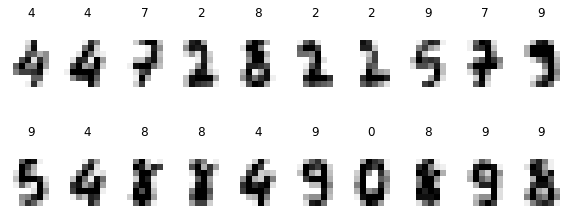

In [32]:
from sklearn.pipeline import Pipeline

km = KMeans(n_clusters = 10, random_state = seed)
pca = PCA(n90)

clf = Pipeline(steps = [('PCA', pca), ('k-Means', km)])

ydpca = clf.fit_predict(X)

ttpca = ytrans(ydpca, y)
ydpcat = ttpca[ydpca]
digiplot(X[-ndigi:], ydpcat[-ndigi:])

Die Ergebnisse sind nur unwesentlich schlechter als im Fall ohne PCA.

In [33]:
print(metrics.classification_report(y, ydpcat))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       178
           1       0.61      0.30      0.40       182
           2       0.84      0.83      0.84       177
           3       0.87      0.85      0.86       183
           4       0.98      0.91      0.94       181
           5       0.92      0.75      0.82       182
           6       0.97      0.98      0.98       181
           7       0.82      0.98      0.89       179
           8       0.45      0.58      0.51       174
           9       0.57      0.77      0.66       180

    accuracy                           0.79      1797
   macro avg       0.80      0.79      0.79      1797
weighted avg       0.80      0.79      0.79      1797



Die Daten mit denen wir hier gearbeitet haben hatten dabei die
reduzierte Dimension

In [34]:
pca.fit_transform(X).shape

(1797, 20)

## Zusammenfassung

- mit SVD können lineare Modelle bzw. hochdimensionale Daten vereinfacht werden

- die Berechnung von Singulärwerten und -vektoren kann mit Methoden der linearen Algebra
oder der konvexen, restringierten Optimierung erfolgen